# GradCAM for Objectness Visualization for YOLOv3

##### 0.  Clone the YOLOv3 Repo

In [1]:
from IPython.display import clear_output

!git clone https://github.com/zzh8829/yolov3-tf2

clear_output()

##### 1. Download and Convert Pretrained Darknet Weight

In [2]:
%cd yolov3-tf2/

!wget https://pjreddie.com/media/files/yolov3.weights -O data/yolov3.weights
!python convert.py

clear_output()

%cd ../

##### 2.  Get Some Sample Images

In [3]:
from IPython.display import clear_output

%cd yolov3-tf2/

!wget https://miro.medium.com/max/1352/1*UCgdiL0mhsMu8PTBBqtKtg.jpeg -O data/beach.jpg

!wget https://d.newsweek.com/en/full/1658757/california-wildfire-smoke.jpg -O data/fire.jpg

!wget https://www.gopio.org.my/wp-content/uploads/2015/12/web-pic-1024x737.png -O data/flood.jpg

clear_output()

%cd ../

##### 3. Initialize Detector

In [4]:
%cd yolov3-tf2

import tensorflow as tf
import sys
from absl import app, logging, flags
from absl.flags import FLAGS
import time
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from yolov3_tf2.models import Darknet, YoloConv, YoloOutput, yolo_anchors, yolo_anchor_masks, YoloV3
from yolov3_tf2.dataset import transform_images, load_tfrecord_dataset
from yolov3_tf2.utils import draw_outputs

flags.DEFINE_string('classes', './data/coco.names', 'path to classes file')
flags.DEFINE_string('weights', './checkpoints/yolov3.tf',
                    'path to weights file')
flags.DEFINE_boolean('tiny', False, 'yolov3 or yolov3-tiny')
flags.DEFINE_integer('size', 416, 'resize images to')
flags.DEFINE_string('image', './data/girl.png', 'path to input image')
flags.DEFINE_string('tfrecord', None, 'tfrecord instead of image')
flags.DEFINE_string('output', './output.jpg', 'path to output image')
flags.DEFINE_integer('num_classes', 80, 'number of classes in the model')

app._run_init(['yolov3'], app.parse_flags_with_usage)

physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)

%cd ../

/content/yolov3-tf2
/content


In [5]:
def YOLOGradCAM(size=None, channels=3, last=True, anchors=yolo_anchors,
           masks=yolo_anchor_masks, classes=80):
    '''
    args:
    1) size: 
        the img resolution for the YOLOv3 (typically 416)
        just leave it as None for flexibility
    2) channels
        number of channels (typically 3, because RGB images)
    3) last 
        last layers before the output layer or not
        usually we plot the GradCAM visualization of the last layers before the output layer
        but you may plot other layer also (i.e., the 3 output of DarkNet-53)
    4) anchors
        yolo anchor boxes
    5) masks
        yolo anchor masks
    6) classes
        number of classes (MS-COCO is 80 classes)
    '''
    x = inputs = tf.keras.layers.Input([size, size, channels], name='input')

    x_36, x_61, x_91 = Darknet(name='yolo_darknet')(x) # the 3 outputs of DarkNet-53

    x_0 = YoloConv(512, name='yolo_conv_0')(x_91)
    output_0 = YoloOutput(512, len(masks[0]), classes, name='yolo_output_0')(x_0)

    x_1 = YoloConv(256, name='yolo_conv_1')((x_0, x_61))
    output_1 = YoloOutput(256, len(masks[1]), classes, name='yolo_output_1')(x_1)

    x_2 = YoloConv(128, name='yolo_conv_2')((x_1, x_36))
    output_2 = YoloOutput(128, len(masks[2]), classes, name='yolo_output_2')(x_2)

    outputs = [output_0, output_1, output_2] # output of the 3 head models of YOLOv3

    # take note!
    # each output is (BS, N, N, Anc, Preds), where
    #   BS is batch size
    #   N is the size of outputs (13, 26, or 52)
    #   Anc is the number of anchors per output (3)
    #   Preds is (x, y, w, h, obj, ...cls)), dimension is 5 + number of class
    # a typical output is (1, 13, 13, 3, 85), (1, 26, 26, 3, 85), (1, 52, 52, 3, 85)
    
    # get objectnes_scores
    objectnes_scores = []
    # loop output for each head model
    for out_idx in range(3):
        # get (BS, N, N, Anc, obj only)
        obj_0 = outputs[out_idx][:,:,:,0,4] # get (1, N, N, Anc=0, obj only)
        obj_1 = outputs[out_idx][:,:,:,1,4] # get (1, N, N, Anc=1, obj only)
        obj_2 = outputs[out_idx][:,:,:,2,4] # get (1, N, N, Anc=2, obj only)

        # each grid (N, N) in obj_0 to obj_2 are prediction on the same thing
        # just with diff anchor aspect ratio
        # we will get the max predictions among all (collapse prediction of each anchor into one)
        obj_0 = tf.expand_dims(obj_0, axis=1)
        obj_1 = tf.expand_dims(obj_1, axis=1)
        obj_2 = tf.expand_dims(obj_2, axis=1)
        obj = tf.concat((obj_0, obj_1, obj_2), axis=1)
        obj = tf.reduce_max(obj, axis=1)
        
        # apply sigmoid, because the objectness score here will be sigmoid-ed by the decoder + NMS layers
        obj = tf.sigmoid(obj)

        objectnes_scores.append(obj)

    # if plot GradCAM for last layers
    if last:
        fmaps = [x_2, x_1, x_0]
        objectnes_scores.reverse()
    # if plot GradCAM for DarkNet-53 outputs
    else:
        fmaps = [x_36, x_61, x_91]

    # fmaps is the layers we want to backprop the gradients to
    # objectness_score is the prediction on the objectness of each grid of each output
    return tf.keras.models.Model(inputs, (output_0, output_1, output_2, fmaps, objectnes_scores), name='grad_cam')

##### 4. Utilities function

In [6]:
def YOLO_make_gradcam_heatmap(img_array, grad_cam):
    # Then, we compute the gradient of the objectness score
    # with respect to the activations of the targetted layers
    heatmaps = []
    for i in range(3):
        with tf.GradientTape() as tape:
            _, _, _, last_conv_layer_outputs, objs = grad_cam(img_array)
            last_conv_layer_output =last_conv_layer_outputs[i]
            objs = objs[i] # first dim is batch size, ignore it

        # This is the gradient of the output neuron (objectness scores)
        # with regard to the output feature map of the targetted layers
        grads = tape.gradient(objs, last_conv_layer_output)

        # This is a vector where each entry is the mean intensity of the gradient
        # over a specific feature map channel
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

        # We multiply each channel in the feature map array
        # by "how important this channel is" with regard to the objectness scores
        # then sum all the channels to obtain the heatmap "objectness" activation
        last_conv_layer_output = last_conv_layer_output[0]
        heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)

        # For visualization purpose, we will also normalize the heatmap between 0 & 1
        heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

        # append
        heatmaps.append(heatmap.numpy())

    return heatmaps

In [7]:
import matplotlib.cm as cm

def save_and_display_gradcam(img_array, heatmap, alpha=0.4):
    # convert img eager tensor to np array in range 0-255
    img = np.array(img_array[0])
    img = np.uint8(255 * img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    return superimposed_img

In [8]:
# set the font globally
def plot_superimposed(superimposed_imgs):
    plt.rcParams["font.serif"] = ["Times New Roman"]
    fig = plt.figure(figsize= (13, 4.75))
    fig.tight_layout()
    fig.set_dpi(112)
    # fig.subplots_adjust(top=0.75)
    fig.suptitle('Comparison of GradCAM on the Last Convolution Layers of the Given YOLOv3 Module', fontsize=14)
    axs = fig.subplots(1, 3)
    i = 0  

    axs[i].imshow(superimposed_imgs[0])
    axs[i].axis('off')
    axs[i].set_title("YOLOv3 Head Model 1", fontsize=14)
    i += 1

    axs[i].imshow(superimposed_imgs[1])
    axs[i].axis('off')
    axs[i].set_title("YOLOv3 Head Model 2", fontsize=14)
    i += 1

    axs[i].imshow(superimposed_imgs[2])
    axs[i].axis('off')
    axs[i].set_title("YOLOv3 Head Model 3", fontsize=14)
    i += 1

    plt.show()

##### 5. Demo

In [9]:
# load the pretrained YOLOv3 on MS-COCO dataset
%cd yolov3-tf2

yolo = YoloV3(classes=FLAGS.num_classes, training=True)
yolo.load_weights(FLAGS.weights).expect_partial()
logging.info('weights loaded')

%cd ../

/content/yolov3-tf2


I1003 15:55:38.778760 140052108728192 <ipython-input-9-816cf6c890bd>:5] weights loaded


/content


In [10]:
# initialize the detector
LAST = True
tf.keras.backend.clear_session()
yolo_grad_cam = YOLOGradCAM(classes=FLAGS.num_classes, last=LAST)

# transfer learning
layer_names = []
for layer in yolo.layers:
    layer_names.append(layer.name)
  
for layer_name in layer_names:
    if 'boxes' in layer_name or 'nms' in layer_name:
        continue
    yolo_grad_cam.get_layer(layer_name).set_weights(
        yolo.get_layer(layer_name).get_weights()
    )

/content/yolov3-tf2
/content


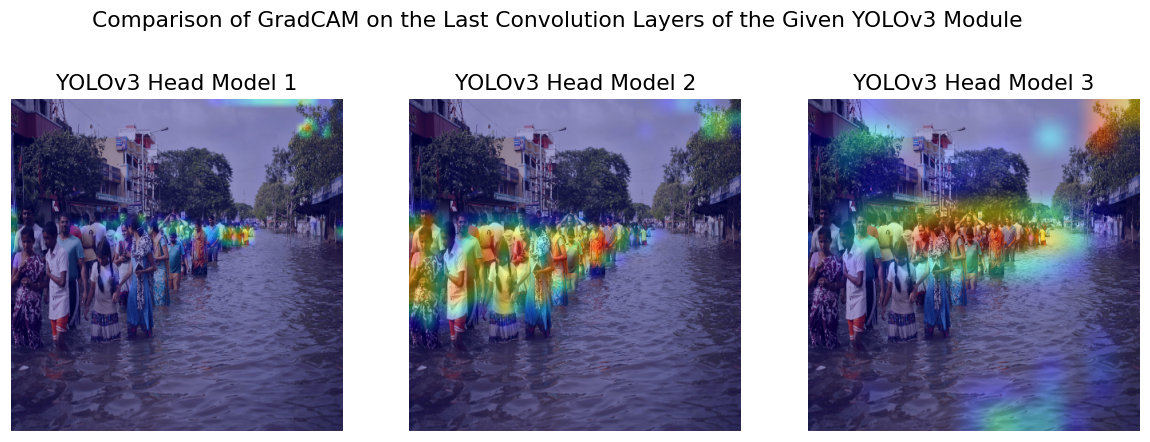

/content/yolov3-tf2
/content


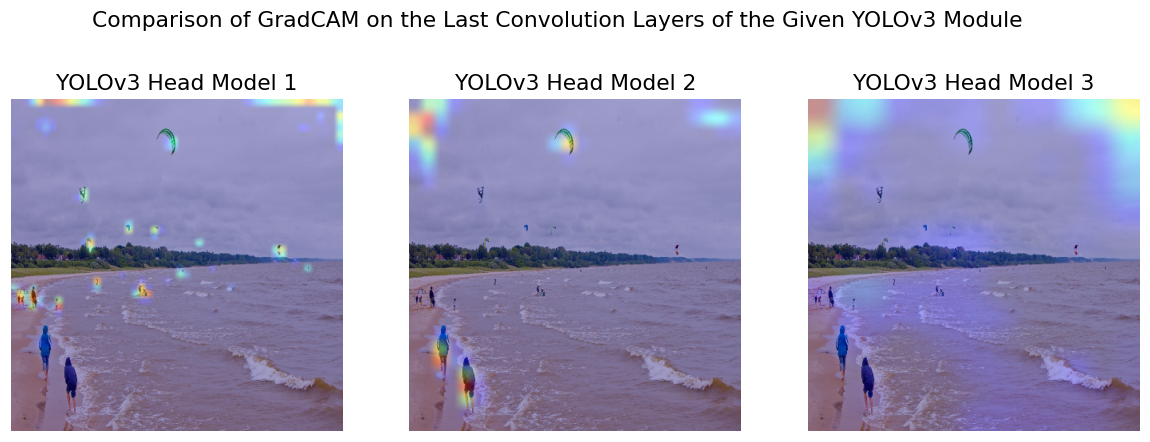

/content/yolov3-tf2
/content


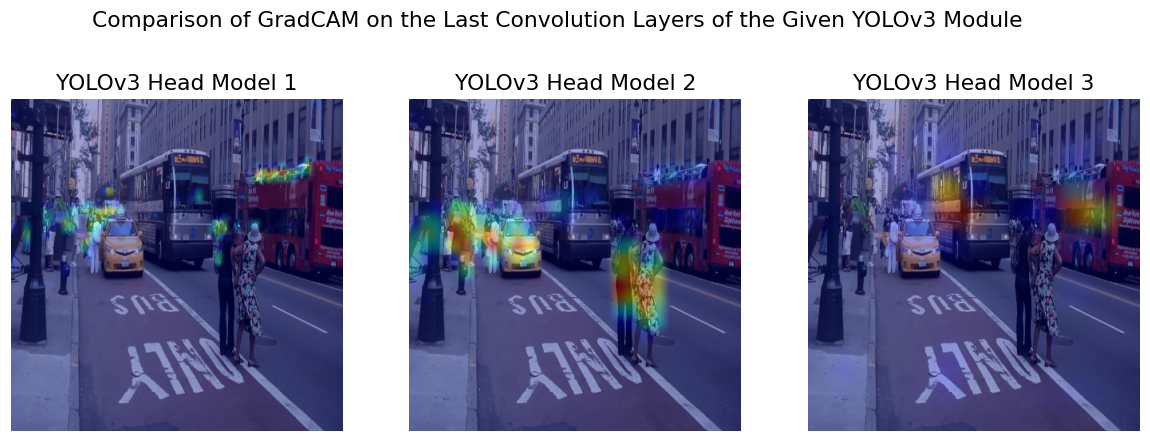

In [15]:
image_list = ['data/flood.jpg', 'data/beach.jpg', 'data/street.jpg']

# load the image
for img_path in image_list:
    %cd yolov3-tf2
    FLAGS.image = img_path

    img_raw = tf.image.decode_image(
        open(FLAGS.image, 'rb').read(), channels=3)

    img = tf.expand_dims(img_raw, 0)
    img = transform_images(img, FLAGS.size)
    %cd ../

    # use the GradCAM-YOLO to create the heatmap for the three output
    heatmaps = YOLO_make_gradcam_heatmap(img, yolo_grad_cam)

    # superimpose each heatmap onto the original input image
    yolo_superimposed_imgs = []
    for i in range(3):
        yolo_superimposed_img = save_and_display_gradcam(img, heatmaps[i], alpha=0.6)
        yolo_superimposed_imgs.append(yolo_superimposed_img)

    # plot the superimposed images
    plot_superimposed(yolo_superimposed_imgs)

As shown in the plots above, we can see that the GradCAM Heatmap visualize where the objects are detected.

From Left to Right:
- Left  : The heatmap highlighted small objects
- Mid   : The heatmap highlighted middle-sized objects
- Right : The heatmap highlighted large-sized objects

This is because each of the head model in YOLOv3 is responsible in detecting small, middle-sized, and large objects, respectively.

## Representation Similarity Analysis (RSA)
Part 2 will discuss how GradCAM can be used to visualize the results of RSA